VGG16 Model

In [1]:
from keras.layers import Dense, Flatten
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras import optimizers
import keras
import numpy as np
import os
import json
import zipfile
%pip install mlflow
import mlflow
from urllib.parse import urlparse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import gdown


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [47]:
try:
  dataset_url = "https://drive.google.com/file/d/1LzyDOlngik_7aPYnPeEakreXt5tuZ423/view?usp=drive_link"
  zip_download_dir =  "content/"
  file_id = dataset_url.split("/")[-2]
  prefix = "https://drive.google.com/uc?/export=download&id="
  gdown.download(prefix + file_id, zip_download_dir)

except Exception as e:
  raise e

Downloading...
From (original): https://drive.google.com/uc?/export=download&id=1LzyDOlngik_7aPYnPeEakreXt5tuZ423
From (redirected): https://drive.google.com/uc?%2Fexport=download&id=1LzyDOlngik_7aPYnPeEakreXt5tuZ423&confirm=t&uuid=c514b44b-6b2d-4990-b6ca-58bf5acb2ba5
To: /content/content/p22.zip
100%|██████████| 153M/153M [00:07<00:00, 21.9MB/s]


In [48]:
try:
  with zipfile.ZipFile('content/p22.zip', "r") as zip_ref:
      zip_ref.extractall('content/')

except Exception as e:
  raise e

In [49]:
data = 'content/p22/train'

In [50]:
# params
params = {
    "LEARNING_RATE": 0.02,
    "CLASSES": 2,
    "EPOCHS": 40,
    "INCLUDE_TOP": False,
    "BATCH_SIZE": 64,
    "WEIGHTS": "imagenet",
    "IMAGE_SIZE": [224, 224, 3],
    "MOMENTUM": 0.9
}

In [51]:
# mlflow configs
MLFLOW_TRACKING_URI = "https://dagshub.com/kalema3502/MIIA-Pothole-Image-classification.mlflow"
MLFLOW_TRACKING_USERNAME = "kalema3502"
MLFLOW_TRACKING_PASSWORD = "fb3845efcc3b2e46a4157b1d2c977a21e02dd16e"

In [52]:
# base model
base_model = VGG16(input_shape=params['IMAGE_SIZE'], weights=params['WEIGHTS'], include_top=params['INCLUDE_TOP'])
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [53]:
# freeze hidden layers
for layer in base_model.layers:
    layer.trainable = False

# create custom output(dense) layer
output = Dense(params['CLASSES'], activation="softmax") (Flatten() (base_model.output))

# custom model
new_model = Model(inputs=base_model.input, outputs=output)
new_model.compile(
            optimizer=optimizers.SGD(learning_rate=params['LEARNING_RATE'], momentum=params['MOMENTUM']),
            loss=keras.losses.CategoricalCrossentropy(),
            metrics=["accuracy"]
        )
new_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [54]:
# Augmentation
datagenerator_kwargs = dict(
            rescale=1./255,
            validation_split=0.20
        )
dataflow_kwargs = dict(
            target_size=params['IMAGE_SIZE'][:-1],
            batch_size=params['BATCH_SIZE'],
            interpolation="bilinear"
        )
train_datagenerator = ImageDataGenerator(
                rotation_range=40,
                horizontal_flip=True,
                width_shift_range=20,
                height_shift_range=20,
                shear_range=0.2,
                zoom_range=0.2,
                **datagenerator_kwargs
            )
validation_datagenerator = ImageDataGenerator(
               **datagenerator_kwargs
            )

# train test sets
train_set = train_datagenerator.flow_from_directory(
            directory=data,
            subset='training',
            shuffle=True,
            class_mode="categorical",
            **dataflow_kwargs
        )
validation_set = validation_datagenerator.flow_from_directory(
            directory=data,
            subset='validation',
            shuffle=True,
            class_mode="categorical",
            **dataflow_kwargs
        )


Found 942 images belonging to 2 classes.
Found 235 images belonging to 2 classes.


In [55]:
# training
from datetime import datetime
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

os.makedirs('artifacts/', exist_ok=True)

steps_per_epoch = train_set.samples // train_set.batch_size
validation_steps = validation_set.samples // validation_set.batch_size

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=1e-5)

checkpoint = ModelCheckpoint(filepath='artifacts/model_p22.h5',
                             verbose=1,
                             save_best_only=True)

callbacks = [checkpoint, lr_reducer]
start = datetime.now()

new_model.fit_generator(generator=train_set,
                        validation_data=validation_set,
                        epochs=params['EPOCHS'],
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps,
                        callbacks=callbacks,
                        verbose=1)

duration = datetime.now() - start
print(f"Training completed in time: {duration}")

<ipython-input-55-2aea3b50742d>:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  new_model.fit_generator(generator=train_set,


Epoch 1/40
14/14 [==============================] - ETA: 0s - loss: 70.2265 - accuracy: 0.5103
Epoch 1: val_loss improved from inf to 60.60431, saving model to artifacts/model_p22.h5
14/14 [==============================] - 27s 2s/step - loss: 70.2265 - accuracy: 0.5103 - val_loss: 60.6043 - val_accuracy: 0.5312 - lr: 0.0200
Epoch 2/40


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - ETA: 0s - loss: 75.6507 - accuracy: 0.5410
Epoch 2: val_loss improved from 60.60431 to 58.38747, saving model to artifacts/model_p22.h5
14/14 [==============================] - 22s 2s/step - loss: 75.6507 - accuracy: 0.5410 - val_loss: 58.3875 - val_accuracy: 0.5417 - lr: 0.0200
Epoch 3/40
14/14 [==============================] - ETA: 0s - loss: 24.7422 - accuracy: 0.5604
Epoch 3: val_loss improved from 58.38747 to 12.14718, saving model to artifacts/model_p22.h5
14/14 [==============================] - 20s 1s/step - loss: 24.7422 - accuracy: 0.5604 - val_loss: 12.1472 - val_accuracy: 0.7031 - lr: 0.0200
Epoch 4/40
14/14 [==============================] - ETA: 0s - loss: 10.4783 - accuracy: 0.7016
Epoch 4: val_loss improved from 12.14718 to 9.14066, saving model to artifacts/model_p22.h5
14/14 [==============================] - 22s 2s/step - loss: 10.4783 - accuracy: 0.7016 - val_loss: 9.1407 - val_accuracy: 0.7031 - lr: 0.0200
Epoch 5/40
14/14 

KeyboardInterrupt: 

In [56]:
# model evaluation
best_model = load_model('artifacts/model_p22.h5')

results = best_model.evaluate(validation_set)

scores = {'loss': results[0], 'accuracy': results[1]}

try:
    with open('scores.json', 'w') as json_file:
        json.dump(scores, json_file)
except IOError as e:
    raise IOError(f"An error occurred while writing to the file: {e}")

4/4 [==============================] - 10s 3s/step - loss: 4.2385 - accuracy: 0.7660


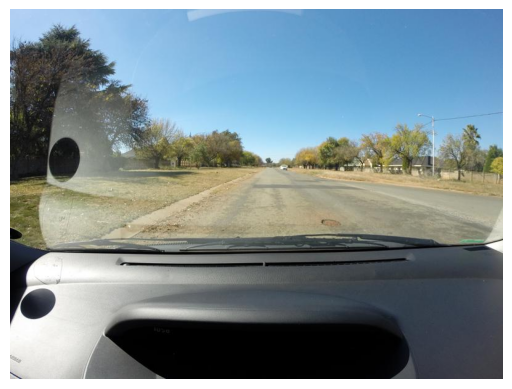

1/1 [==============================] - 0s 143ms/step
Top Label: Has Pothole
score: [0.26894143 0.73105854]


In [69]:
%pip install opencv-python
import tensorflow as tf
import cv2
image = cv2.imread('/content/content/dataset/test/AFDbfuMGEQCzsYb.JPG')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()
# Preprocess the image
image = cv2.resize(image, (224, 224))
image = image.astype('float32') / 255
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

# Define the prediction function
def prediction_function(image):
    best_model = load_model('artifacts/model_p22.h5')
    return best_model.predict(image)

# explainer = lime_image.LimeImageExplainer()

predictions = prediction_function(image)

class_names = ['No Pothole', 'Has Pothole']
score = tf.nn.softmax(predictions[0])
print(f"Top Label: {class_names[np.argmax(score)]}")
print(f"score: {score}")

In [70]:
test_dir = '/content/content/dataset/test/'

submission_data = {'Image_ID': [], 'Label': []}

for image_file in os.listdir(test_dir):
    image_path = os.path.join(test_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image.astype('float32') / 255
    image = np.expand_dims(image, axis=0)

    predictions = prediction_function(image)
    probability_class_1 = predictions[0][1]

    submission_data['Image_ID'].append(image_file.split('.')[0])
    submission_data['Label'].append(probability_class_1)



1/1 [==============================] - 0s 131ms/step


In [71]:
import pandas as pd
vgg_p22_df = pd.DataFrame(submission_data)


In [72]:
vgg_p22_df

,Image_ID,Label
0,PNSqAIyIRUfqHZG,1.000000e+00
1,uxrKMVQcTvWLDeM,1.000000e+00
2,YrdasLJubIViQir,6.366423e-03
3,YzpaAdrVUabLgEv,1.517763e-28
4,ONuIUuImEJlohHP,1.230025e-02
...,...,...
1645,DkyEUkAMiLEdKud,1.615997e-03
1646,kvesbcrtTOohiLT,4.591820e-02
1647,onEDgyOAxNCjWqJ,1.242781e-34
1648,NnmdcLFMyzqzXqf,1.000000e+00


In [74]:
vgg_p22_df.to_csv('vgg_p22.csv', index=False)

Custom Model

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import numpy as np
import os
import json
import zipfile
%pip install mlflow
import mlflow
from urllib.parse import urlparse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import gdown


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [63]:
params = {
    "LEARNING_RATE": 0.01,
    "CLASSES": 2,
    "EPOCHS": 30,
    "BATCH_SIZE": 80,
    "IMAGE_SIZE": [224, 224, 3],
}

In [64]:
conv1_filters = 64
conv2_filters = 128
conv3_filters = 96
conv4_filters = 64
dense_units = 320

# Create the model
model = Sequential([
    Conv2D(conv1_filters, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(conv2_filters, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(conv3_filters, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(conv4_filters, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(dense_units, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 96)        110688    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 96)        0

In [65]:
# Define data generator for training data with augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    directory=data,
    target_size=params['IMAGE_SIZE'][:-1],
    batch_size=params['BATCH_SIZE'],
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    directory=data,
    target_size=params['IMAGE_SIZE'][:-1],
    batch_size=params['BATCH_SIZE'],
    class_mode='categorical',
    subset='validation'
)

Found 942 images belonging to 2 classes.
Found 235 images belonging to 2 classes.


In [66]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

os.makedirs('artifacts/', exist_ok=True)

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=1e-5)

checkpoint = ModelCheckpoint(filepath='artifacts/custom_model_p22.h5',
                             verbose=1,
                             save_best_only=True)

callbacks = [checkpoint, lr_reducer]
start = datetime.now()

model.fit_generator(generator=train_generator,
                        validation_data=validation_generator,
                        epochs=params['EPOCHS'],
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps,
                        callbacks=callbacks,
                        verbose=1)

<ipython-input-66-1a717e0b5fa4>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,


Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.8149 - accuracy: 0.5754
Epoch 1: val_loss improved from inf to 0.71957, saving model to artifacts/custom_model_p22.h5
11/11 [==============================] - 26s 1s/step - loss: 0.8149 - accuracy: 0.5754 - val_loss: 0.7196 - val_accuracy: 0.4938 - lr: 0.0010
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - ETA: 0s - loss: 0.6430 - accuracy: 0.6415
Epoch 2: val_loss improved from 0.71957 to 0.63317, saving model to artifacts/custom_model_p22.h5
11/11 [==============================] - 5s 446ms/step - loss: 0.6430 - accuracy: 0.6415 - val_loss: 0.6332 - val_accuracy: 0.6375 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.5505 - accuracy: 0.7273
Epoch 3: val_loss did not improve from 0.63317
11/11 [==============================] - 5s 490ms/step - loss: 0.5505 - accuracy: 0.7273 - val_loss: 0.6774 - val_accuracy: 0.7437 - lr: 0.0010
Epoch 4/30
11/11 [==============================] - ETA: 0s - loss: 0.4934 - accuracy: 0.7657
Epoch 4: val_loss improved from 0.63317 to 0.55808, saving model to artifacts/custom_model_p22.h5
11/11 [==============================] - 5s 465ms/step - loss: 0.4934 - accuracy: 0.7657 - val_loss: 0.5581 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/30
11/11 [==============================] - ET

In [68]:
 # model evaluation
best_model = load_model('artifacts/custom_model_p22.h5')

results = best_model.evaluate(validation_generator)

scores = {'loss': results[0], 'accuracy': results[1]}

try:
    with open('scores.json', 'w') as json_file:
        json.dump(scores, json_file)
except IOError as e:
    raise IOError(f"An error occurred while writing to the file: {e}")

3/3 [==============================] - 1s 308ms/step - loss: 0.6832 - accuracy: 0.7745


In [26]:
# mlflow configs
os.environ["MLFLOW_TRACKING_URI"]= MLFLOW_TRACKING_URI
os.environ["MLFLOW_TRACKING_USERNAME"]= MLFLOW_TRACKING_USERNAME
os.environ["MLFLOW_TRACKING_PASSWORD"]= MLFLOW_TRACKING_PASSWORD

In [27]:
# experiment tracking
mlflow.set_registry_uri(MLFLOW_TRACKING_URI)
tracking_url_type_store= urlparse(mlflow.get_tracking_uri()).scheme

with mlflow.start_run():
    mlflow.log_params(params)
    mlflow.log_metrics(
        {"loss": results[0], "accuracy": results[1]}
    )

    if tracking_url_type_store != "file":
        mlflow.keras.log_model(best_model, "model", registered_model_name="CustomModel")
    else:
        mlflow.keras.log_model(best_model, "model")

2024/05/31 14:04:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'CustomModel' already exists. Creating a new version of this model...
2024/05/31 14:04:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: CustomModel, version 16
Created version '16' of model 'CustomModel'.


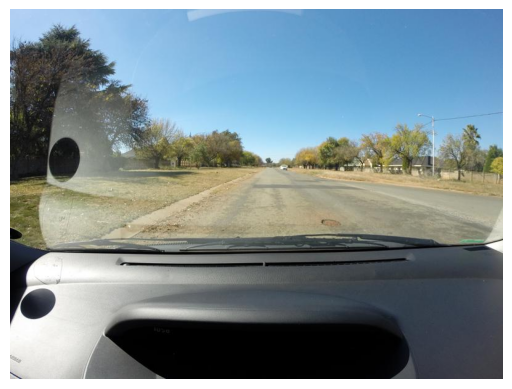

1/1 [==============================] - 0s 121ms/step
Top Label: Has Pothole
score: [0.3530286 0.6469714]


In [75]:
%pip install opencv-python
import cv2
image = cv2.imread('/content/content/dataset/test/AFDbfuMGEQCzsYb.JPG')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()
# Preprocess the image
image = cv2.resize(image, (224, 224))
image = image.astype('float32') / 255
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

# Define the prediction function
def prediction_function(image):
    best_model = load_model('artifacts/custom_model_p22.h5')
    return best_model.predict(image)

# explainer = lime_image.LimeImageExplainer()

predictions = prediction_function(image)

class_names = ['No Pothole', 'Has Pothole']
score = tf.nn.softmax(predictions[0])
print(f"Top Label: {class_names[np.argmax(score)]}")
print(f"score: {score}")

In [76]:
test_dir = '/content/content/dataset/test/'

submission_data = {'Image_ID': [], 'Label': []}

for image_file in os.listdir(test_dir):
    image_path = os.path.join(test_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image.astype('float32') / 255
    image = np.expand_dims(image, axis=0)

    predictions = prediction_function(image)
    probability_class_1 = predictions[0][1]

    submission_data['Image_ID'].append(image_file.split('.')[0])
    submission_data['Label'].append(probability_class_1)

custom_df = pd.DataFrame(submission_data)

1/1 [==============================] - 0s 134ms/step


In [77]:
custom_df


,Image_ID,Label
0,PNSqAIyIRUfqHZG,0.527842
1,uxrKMVQcTvWLDeM,0.871316
2,YrdasLJubIViQir,0.013013
3,YzpaAdrVUabLgEv,0.004693
4,ONuIUuImEJlohHP,0.012169
...,...,...
1645,DkyEUkAMiLEdKud,0.010581
1646,kvesbcrtTOohiLT,0.011389
1647,onEDgyOAxNCjWqJ,0.017806
1648,NnmdcLFMyzqzXqf,0.520025


In [78]:
custom_df.to_csv('custom_p22.csv', index=False)

Aggregate results from both models

In [36]:
ids = vgg_df['Image_ID'].values

In [37]:
ids

array(['PNSqAIyIRUfqHZG', 'uxrKMVQcTvWLDeM', 'YrdasLJubIViQir', ...,
       'onEDgyOAxNCjWqJ', 'NnmdcLFMyzqzXqf', 'pjOzBwldjHlgeNG'],
      dtype=object)

In [38]:
vgg_labels = vgg_df['Label'].values

In [39]:
vgg_labels

array([1.0000000e+00, 1.0000000e+00, 6.5273315e-10, ..., 1.3051957e-16,
       1.0000000e+00, 1.0000000e+00], dtype=float32)

In [40]:
custom_labels = custom_df['Label'].values

In [41]:
custom_labels

array([4.9341487e-04, 9.9998415e-01, 9.7920329e-06, ..., 7.8886858e-04,
       9.6486919e-02, 9.9120200e-01], dtype=float32)

In [42]:

average_labels = (vgg_labels + custom_labels) / 2


In [43]:
average_labels

array([5.0024670e-01, 9.9999207e-01, 4.8963429e-06, ..., 3.9443429e-04,
       5.4824346e-01, 9.9560100e-01], dtype=float32)

In [44]:


import pandas as pd
aggregate_df = pd.DataFrame({
    'Image_ID': ids,
    'Label': average_labels
})
aggregate_df


,Image_ID,Label
0,PNSqAIyIRUfqHZG,5.002467e-01
1,uxrKMVQcTvWLDeM,9.999921e-01
2,YrdasLJubIViQir,4.896343e-06
3,YzpaAdrVUabLgEv,1.484558e-07
4,ONuIUuImEJlohHP,1.002760e-05
...,...,...
1645,DkyEUkAMiLEdKud,4.811492e-01
1646,kvesbcrtTOohiLT,4.999403e-01
1647,onEDgyOAxNCjWqJ,3.944343e-04
1648,NnmdcLFMyzqzXqf,5.482435e-01


In [46]:
aggregate_df.to_csv('aggregate.csv', index=False)